In [11]:
import sys
sys.path.append("..")
from dev.ekf_lc_smoothing import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


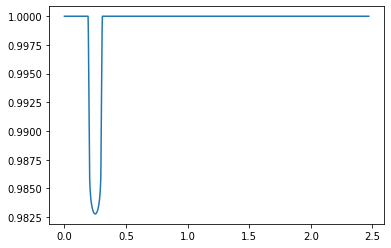

In [9]:
mstar, rstar, m, params, t, model_flux, err_flux = set_params()
lc_time, lc_flux = get_measured_flux()
plt.plot(t, model_flux)